# KDD e Criação do Modelo de Classificação de Complexidade

**Objetivo:** Este notebook tem como objetivo realizar um processo completo de Descoberta de Conhecimento em Dados (KDD) sobre o dataset de chamadas de emergência. O resultado final será um modelo de Machine Learning treinado, capaz de classificar uma chamada como "Simples" ou "Complexa" com base em suas características, para ser utilizado por um agente de IA em um ambiente de simulação.

**Etapas:**
1.  **Carregamento e Limpeza dos Dados:** Leitura do dataset e tratamento de valores ausentes e inconsistências.
2.  **Engenharia de Features:** Criação da nossa variável alvo (`Complexity`) a partir da duração total da chamada.
3.  **Análise Exploratória de Dados (EDA):** Visualização e análise dos dados para extrair insights.
4.  **Pré-processamento:** Preparação dos dados para o modelo (codificação de variáveis categóricas).
5.  **Treinamento, Otimização de Modelos e Balanceamento de Classes:** Aplicação dos algoritmos de treinamento, técnicas de balanceamento, otimização dos hiperparâmetros e Tuning.
6.  **Avaliação de Modelos:** Avaliação da performance dos modelos de treinamento (Logistic Regression, Random Forest).
7.  **Conclusão e Exportação do Modelo:** Escolha do melhor modelo e salvamento para uso futuro.

# 1. Configurações iniciais do projeto

## Instalação das bibliotecas

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


import joblib # Para salvar o modelo

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:,.2f}'.format

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## Carregamento de dados

In [118]:
# Caminho para o arquivo CSV
file_path = '../data/raw/Fire_Department_and_Emergency_Medical_Services_Dispatched_Calls_for_Service_20250904.csv'

try:
    # Usar engine='python' para evitar ParserError comuns em CSVs complexos
    df = pd.read_csv(file_path, engine='python')
    print(f"Dataset carregado com sucesso! Formato: {df.shape}")
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado no caminho especificado: {file_path}")
except Exception as e:
    print(f"Ocorreu um erro inesperado ao ler o arquivo: {e}")

# Visualizar as primeiras linhas e informações básicas
if 'df' in locals():
    display(df.head())
    display(df.info())

Dataset carregado com sucesso! Formato: (242828, 36)


,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,data_as_of,data_loaded_at
0,250020258,T15,25000638,Medical Incident,01/02/2025,01/01/2025,2025 Jan 02 02:59:06 AM,2025 Jan 02 03:01:43 AM,2025 Jan 02 03:01:48 AM,2025 Jan 02 03:04:39 AM,...,1,TRUCK,1.00,9.00,11.00,Excelsior,250020258-T15,POINT (-122.425547474 37.725322562),2025 Jan 02 03:32:08 AM,2025 Jan 09 04:18:22 AM
1,250020501,B04,25000702,Alarms,01/02/2025,01/01/2025,2025 Jan 02 06:48:34 AM,2025 Jan 02 06:51:28 AM,2025 Jan 02 06:51:34 AM,2025 Jan 02 06:54:05 AM,...,1,CHIEF,3.00,4.00,2.00,Marina,250020501-B04,POINT (-122.437514361 37.798742207),2025 Jan 03 03:18:49 AM,2025 Jan 10 04:22:32 AM
2,250022953,T08,25001078,Alarms,01/02/2025,01/02/2025,2025 Jan 02 08:20:57 PM,2025 Jan 02 08:23:06 PM,2025 Jan 02 08:23:15 PM,2025 Jan 02 08:24:31 PM,...,1,TRUCK,3.00,3.00,6.00,South of Market,250022953-T08,POINT (-122.393857286 37.777977132),2025 Jan 03 03:18:49 AM,2025 Jan 10 04:22:32 AM
3,250022603,E14,25001024,Alarms,01/02/2025,01/02/2025,2025 Jan 02 05:59:28 PM,2025 Jan 02 06:02:01 PM,2025 Jan 02 06:02:51 PM,2025 Jan 02 06:04:09 PM,...,1,ENGINE,3.00,7.00,1.00,Outer Richmond,250022603-E14,POINT (-122.481791172 37.784028238),2025 Jan 03 03:18:49 AM,2025 Jan 10 04:22:32 AM
4,250020285,AM122,25000649,Medical Incident,01/02/2025,01/01/2025,2025 Jan 02 03:27:26 AM,2025 Jan 02 03:29:13 AM,2025 Jan 02 03:29:41 AM,2025 Jan 02 03:31:03 AM,...,1,PRIVATE,2.00,10.00,9.00,Portola,250020285-AM122,POINT (-122.402108391 37.724035614),2025 Jan 03 03:18:49 AM,2025 Jan 10 04:22:32 AM


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242828 entries, 0 to 242827
Data columns (total 36 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Call Number                           242828 non-null  int64  
 1   Unit ID                               242828 non-null  object 
 2   Incident Number                       242828 non-null  int64  
 3   Call Type                             242828 non-null  object 
 4   Call Date                             242828 non-null  object 
 5   Watch Date                            242828 non-null  object 
 6   Received DtTm                         242828 non-null  object 
 7   Entry DtTm                            242828 non-null  object 
 8   Dispatch DtTm                         242828 non-null  object 
 9   Response DtTm                         236229 non-null  object 
 10  On Scene DtTm                         189466 non-null  object 
 11  

None

## Limpeza e pré-processamento dos dados

In [119]:
print("Iniciando a limpeza dos dados...")

# 1. Selecionar todas as colunas necessárias
colunas_relevantes = [
    'Call Type',
    'Call Type Group',
    'Original Priority', # Feature chave que estamos reintroduzindo
    'Final Priority',
    'Received DtTm',
    'Available DtTm'
]
df_clean = df[colunas_relevantes].copy()

# 2. Converter colunas de data/hora e remover nulos
for col in ['Received DtTm', 'Available DtTm']:
    df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
df_clean.dropna(subset=colunas_relevantes, inplace=True)

# 3. Calcular a DURAÇÃO TOTAL DO INCIDENTE em minutos
df_clean['Incident Duration (minutes)'] = (df_clean['Available DtTm'] - df_clean['Received DtTm']).dt.total_seconds() / 60.0
df_clean = df_clean[df_clean['Incident Duration (minutes)'] > 0]

# 4. Garantir que as prioridades sejam tratadas corretamente
df_clean['Final Priority'] = pd.to_numeric(df_clean['Final Priority'], errors='coerce')
df_clean['Original Priority'] = pd.to_numeric(df_clean['Original Priority'], errors='coerce') # Garantir que seja numérico
df_clean.dropna(subset=['Final Priority', 'Original Priority'], inplace=True)

print("Limpeza finalizada. Formato do DataFrame limpo:", df_clean.shape)

Iniciando a limpeza dos dados...
Limpeza finalizada. Formato do DataFrame limpo: (192077, 7)


# 2. Engenharia de Features

## Definição da Complexidade

Após uma análise aprofundada, concluímos que usar apenas a duração da chamada como um proxy para a complexidade era uma simplificação que poderia levar a conclusões equivocadas. Um incidente médico simples, por exemplo, poderia ter uma duração longa, enquanto um alarme de incêndio (sempre complexo) poderia ser resolvido rapidamente (alarme falso).

Portanto, adotamos uma definição de complexidade híbrida e mais robusta, baseada em regras de negócio que refletem melhor a realidade operacional de um centro de emergências. Esta abordagem cria uma variável alvo muito mais confiável para o modelo aprender.

Uma chamada será classificada como Complexa (1) se QUALQUER UMA das seguintes condições for verdadeira:

1. **Natureza Grave do Incidente**: O Call Type Group (Grupo do Tipo de Chamada) é 'Fire' ou 'Alarms'. Estas são situações que, por padrão, são sempre tratadas como complexas e exigem despacho e verificação.

2. **Urgência Avaliada por Humanos**: A Final Priority (Prioridade Final) atribuída por um operador é 3 ou maior. Este critério utiliza o julgamento de um especialista humano como uma "verdade fundamental" para identificar emergências.

3. **Duração Longa**: O Incident Duration (minutes) (Duração Total do Incidente) é um outlier estatístico superior. Esta regra captura qualquer tipo de chamada, mesmo as aparentemente simples, que por algum motivo se tornaram excepcionalmente longas e, portanto, complexas na prática.

Uma chamada só será considerada Simples (0) se não se encaixar em nenhum desses critérios.

Definindo a variável alvo 'Complexity' com a regra final...
Chamadas complexas pela Regra 1 (Natureza): 10148
Chamadas complexas pela Regra 2 (Urgência): 144135
Chamadas complexas pela Regra 3 (Duração Anormal > 151.24 min): 2185

--- Distribuição Final da variável 'Complexity' ---
Complexity
1   0.76
0   0.24
Name: proportion, dtype: float64


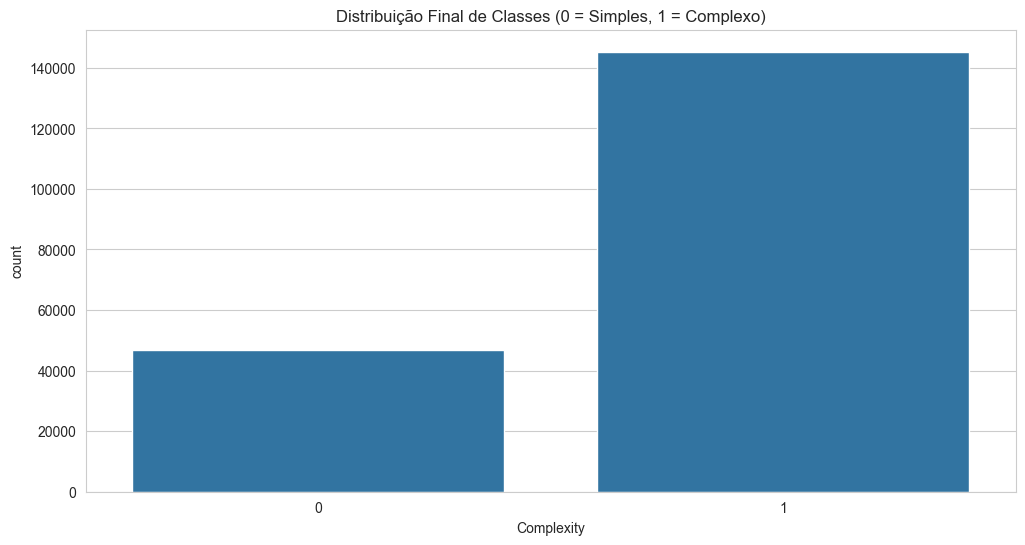

In [120]:
# --- Lógica de Complexidade Definitiva (Híbrida e Robusta) ---

print("Definindo a variável alvo 'Complexity' com a regra final...")

# Critério 1: Natureza Grave (Grupo de Incêndio ou Alarme)
rule1 = df_clean['Call Type Group'].isin(['Fire', 'Alarms'])
print(f"Chamadas complexas pela Regra 1 (Natureza): {rule1.sum()}")

# Critério 2: Urgência Avaliada por Humanos (Prioridade Final >= 3)
rule2 = (df_clean['Final Priority'] >= 3)
print(f"Chamadas complexas pela Regra 2 (Urgência): {rule2.sum()}")

# Critério 3: Duração Anormalmente Longa (Outlier Superior)
Q3 = df_clean['Incident Duration (minutes)'].quantile(0.75)
IQR = Q3 - df_clean['Incident Duration (minutes)'].quantile(0.25)
upper_bound = Q3 + 1.5 * IQR
rule3 = (df_clean['Incident Duration (minutes)'] > upper_bound)
print(f"Chamadas complexas pela Regra 3 (Duração Anormal > {upper_bound:.2f} min): {rule3.sum()}")

# Aplicar a lógica OU: uma chamada é COMPLEXA (1) se QUALQUER critério for verdadeiro
df_clean['Complexity'] = (rule1 | rule2 | rule3).astype(int)

# Verificar a nova distribuição da variável
print("\n--- Distribuição Final da variável 'Complexity' ---")
print(df_clean['Complexity'].value_counts(normalize=True))
sns.countplot(x='Complexity', data=df_clean)
plt.title('Distribuição Final de Classes (0 = Simples, 1 = Complexo)')
plt.show()

# --- CORREÇÃO AQUI ---
# Guardar o dataframe processado com TODAS as features necessárias para o modelo
df_processed = df_clean[['Call Type', 'Call Type Group', 'Original Priority', 'Final Priority', 'Complexity']].copy()

# 3. Análise exploratória (EDA)

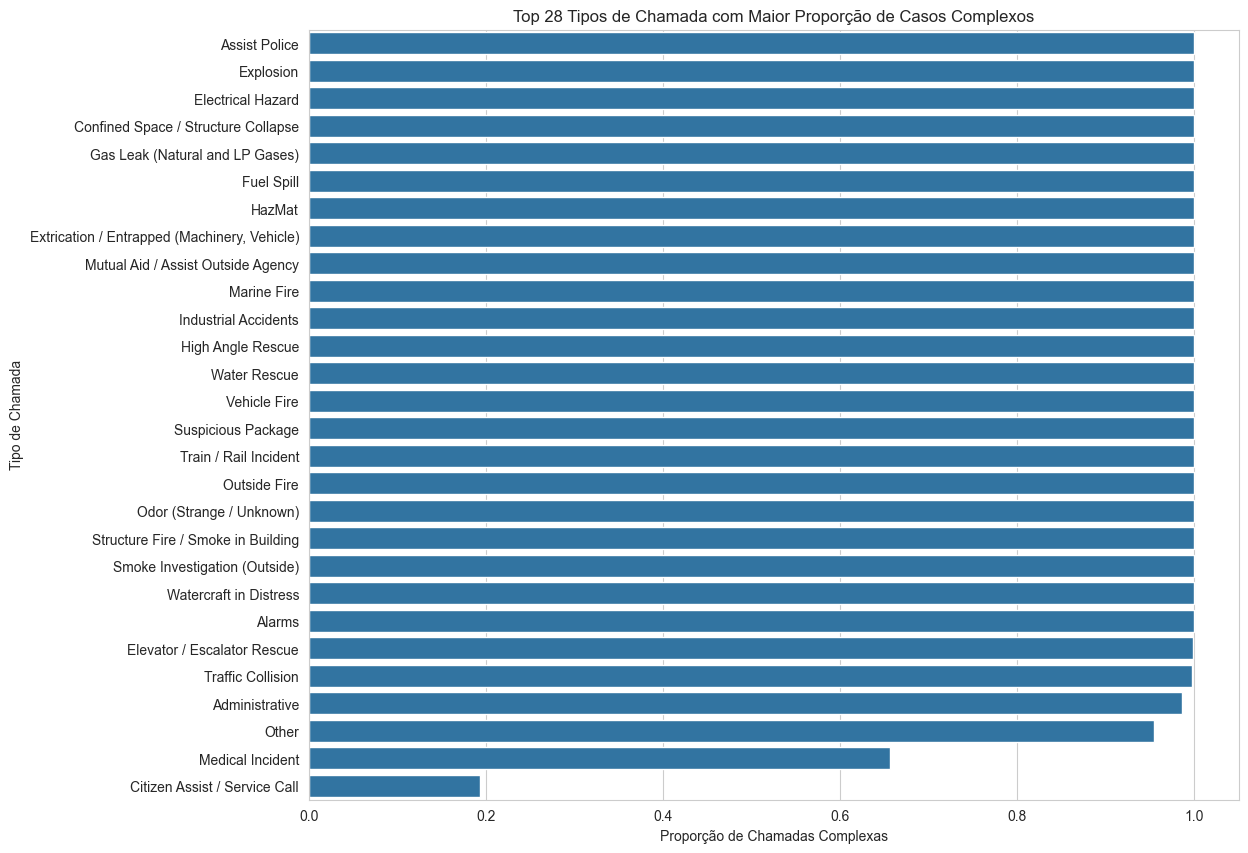

In [121]:
# Análise: Tipos de Chamada mais complexos
# Calcular a proporção de chamadas complexas para cada tipo de chamada

complexity_by_type = df_processed.groupby('Call Type')['Complexity'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(y=complexity_by_type.index[:], x=complexity_by_type.values[:], orient='h')
plt.title(f'Top {len(complexity_by_type)} Tipos de Chamada com Maior Proporção de Casos Complexos')
plt.xlabel('Proporção de Chamadas Complexas')
plt.ylabel('Tipo de Chamada')
plt.show()

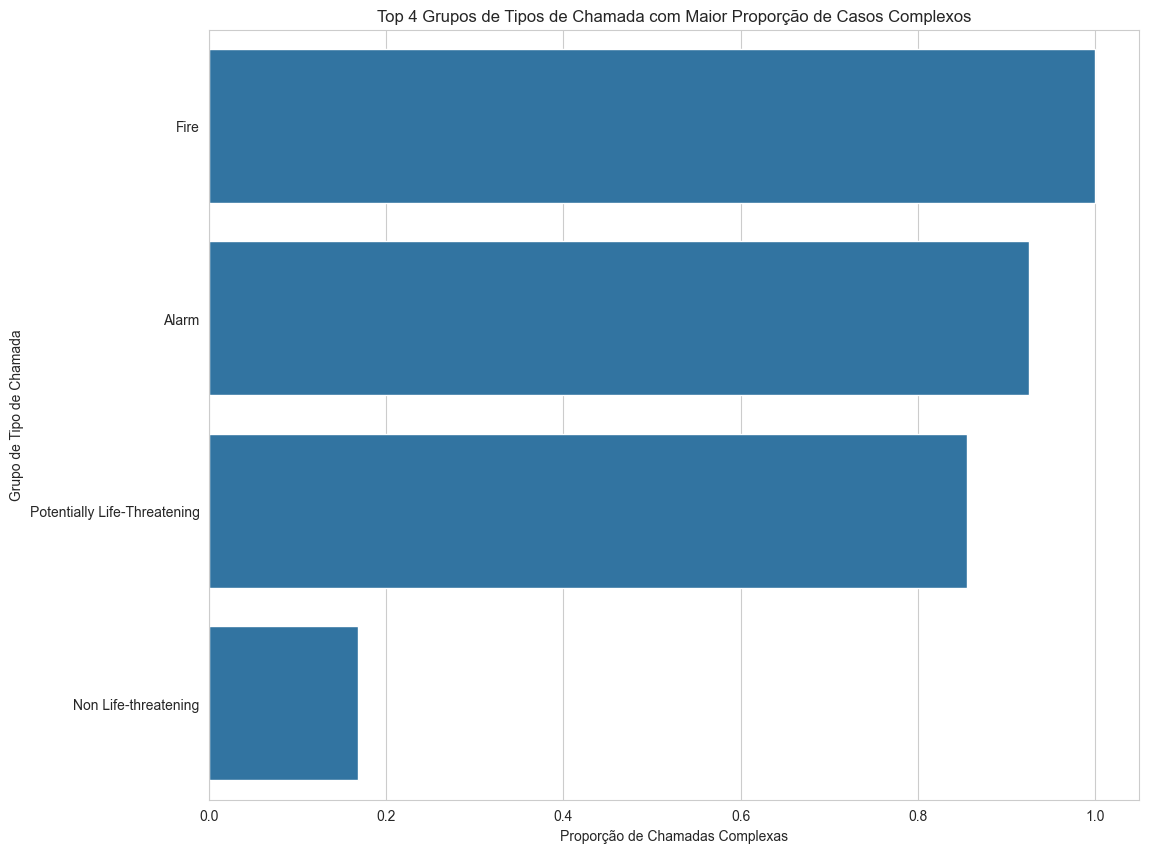

In [122]:
# Análise: Grupos de Tipos de Chamada mais complexos
# Calcular a proporção de chamadas complexas para cada tipo de chamada

complexity_by_type = df_processed.groupby('Call Type Group')['Complexity'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(y=complexity_by_type.index[:], x=complexity_by_type.values[:], orient='h')
plt.title(f'Top {len(complexity_by_type)} Grupos de Tipos de Chamada com Maior Proporção de Casos Complexos')
plt.xlabel('Proporção de Chamadas Complexas')
plt.ylabel('Grupo de Tipo de Chamada')
plt.show()

# 4. Pré processamento

## Preparação para o Modelo - Codificação e Divisão

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

print("Preparando dados para modelagem (versão final com features iniciais)...")

# 1. Definir Features (X) e Alvo (y)
# Estas são as features que o chatbot pode inferir no início da chamada.
categorical_features = ['Call Type', 'Call Type Group']
numerical_features = ['Original Priority'] # Usando a prioridade INICIAL
X = df_processed[categorical_features + numerical_features]
y = df_processed['Complexity']

# 2. Criar o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# 3. Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 4. Aplicar o pré-processador
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Salvar o pré-processador final
joblib.dump(preprocessor, 'feature_preprocessor_final.pkl')

print("Pré-processador final salvo em 'feature_preprocessor_final.pkl'")
print(f"X_train_processed: {X_train_processed.shape}, y_train: {y_train.shape}")
print(f"X_test_processed: {X_test_processed.shape}, y_test: {y_test.shape}")

Preparando dados para modelagem (versão final com features iniciais)...
Pré-processador final salvo em 'feature_preprocessor_final.pkl'
X_train_processed: (134453, 32), y_train: (134453,)
X_test_processed: (57624, 32), y_test: (57624,)


# 5. Framework de Otimização de Modelos

Para encontrar a melhor solução, vamos criar um experimento estruturado para comparar diferentes abordagens.

**1. Algoritmos a serem testados:**
* **Regressão Logística:** Um ótimo baseline, rápido e interpretável.
* **Random Forest:** O nosso melhor modelo da rodada anterior, agora com tuning.
* **LightGBM:** Um modelo de Gradient Boosting de alta performance, geralmente superior ao Random Forest em dados tabulares.

**2. Técnicas de Balanceamento:**
* **Oversampling (SMOTE):** Cria dados sintéticos da classe minoritária.
* **Undersampling (RandomUnderSampler):** Remove aleatoriamente dados da classe majoritária.

**3. Otimização de Hiperparâmetros:**
* Usaremos **`RandomizedSearchCV`**, que é mais eficiente que o `GridSearchCV`. Ele testará um número fixo de combinações de hiperparâmetros aleatoriamente, encontrando ótimas soluções em menos tempo.
* A métrica de otimização será o **`f1_macro`**, que busca um bom equilíbrio entre precisão e recall para ambas as classes.

## Configuração dos Modelos, Parâmetros e Pipelines

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

# Dicionário com os modelos que vamos testar
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}

# Dicionário com as grades de hiperparâmetros para cada modelo
params = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': ['balanced', None]
    }
}

# Técnicas de balanceamento
samplers = {
    'SMOTE (Oversampling)': SMOTE(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42)
}

print("Configuração do experimento finalizada.")

Configuração do experimento finalizada.


## Execução da Validação Cruzada e Tuning

In [125]:
import pandas as pd
from sklearn.metrics import f1_score

results_list = []

# Iterar sobre cada modelo e cada técnica de balanceamento
for model_name, model in models.items():
    for sampler_name, sampler in samplers.items():
        print(f"--- Rodando: {model_name} com {sampler_name} ---")
        
        # 1. Criar o pipeline: primeiro o balanceamento, depois o classificador
        pipeline = ImbPipeline(steps=[('sampler', sampler),
                                      ('classifier', model)])
        
        # 2. Configurar a busca de hiperparâmetros com validação cruzada
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=params[model_name],
            n_iter=10,
            cv=3,
            scoring='f1_macro',
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        
        # 3. Executar a busca nos dados já pré-processados
        search.fit(X_train_processed, y_train)
        
        # 4. Salvar os resultados
        results_list.append({
            'Model': model_name,
            'Sampler': sampler_name,
            'Best Score (f1_macro)': search.best_score_,
            'Best Params': search.best_params_
        })

# Criar um DataFrame com os resultados
df_results = pd.DataFrame(results_list).sort_values(by='Best Score (f1_macro)', ascending=False)

print("\n--- FIM DO EXPERIMENTO ---")

--- Rodando: Logistic Regression com SMOTE (Oversampling) ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
--- Rodando: Logistic Regression com RandomUnderSampler ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
--- Rodando: Random Forest com SMOTE (Oversampling) ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
--- Rodando: Random Forest com RandomUnderSampler ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- FIM DO EXPERIMENTO ---


# 6. Avaliação de Modelos

## Análise dos Resultados do Tuning

In [126]:
print("--- Tabela Comparativa dos Resultados da Validação Cruzada ---")
display(df_results)

# Extrair o melhor resultado geral
best_overall_result = df_results.iloc[0]
best_model_name = best_overall_result['Model']
best_sampler_name = best_overall_result['Sampler']
best_params = best_overall_result['Best Params']

print(f"\n🏆 Melhor Combinação Encontrada 🏆")
print(f"Modelo: {best_model_name}")
print(f"Técnica de Balanceamento: {best_sampler_name}")
print(f"Melhor pontuação (f1_macro na validação): {best_overall_result['Best Score (f1_macro)']:.4f}")
print(f"Melhores Hiperparâmetros: {best_params}")

--- Tabela Comparativa dos Resultados da Validação Cruzada ---


,Model,Sampler,Best Score (f1_macro),Best Params
2,Random Forest,SMOTE (Oversampling),0.91,"{'classifier__n_estimators': 50, 'classifier__..."
3,Random Forest,RandomUnderSampler,0.91,"{'classifier__n_estimators': 100, 'classifier_..."
1,Logistic Regression,RandomUnderSampler,0.91,"{'classifier__solver': 'liblinear', 'classifie..."
0,Logistic Regression,SMOTE (Oversampling),0.91,"{'classifier__solver': 'liblinear', 'classifie..."



🏆 Melhor Combinação Encontrada 🏆
Modelo: Random Forest
Técnica de Balanceamento: SMOTE (Oversampling)
Melhor pontuação (f1_macro na validação): 0.9061
Melhores Hiperparâmetros: {'classifier__n_estimators': 50, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced'}


## Avaliação do Melhor Modelo no Conjunto de Teste

--- Relatório de Classificação Final para: Random Forest com SMOTE (Oversampling) ---
              precision    recall  f1-score   support

           0       0.80      0.92      0.86     14035
           1       0.97      0.93      0.95     43589

    accuracy                           0.93     57624
   macro avg       0.89      0.93      0.90     57624
weighted avg       0.93      0.93      0.93     57624



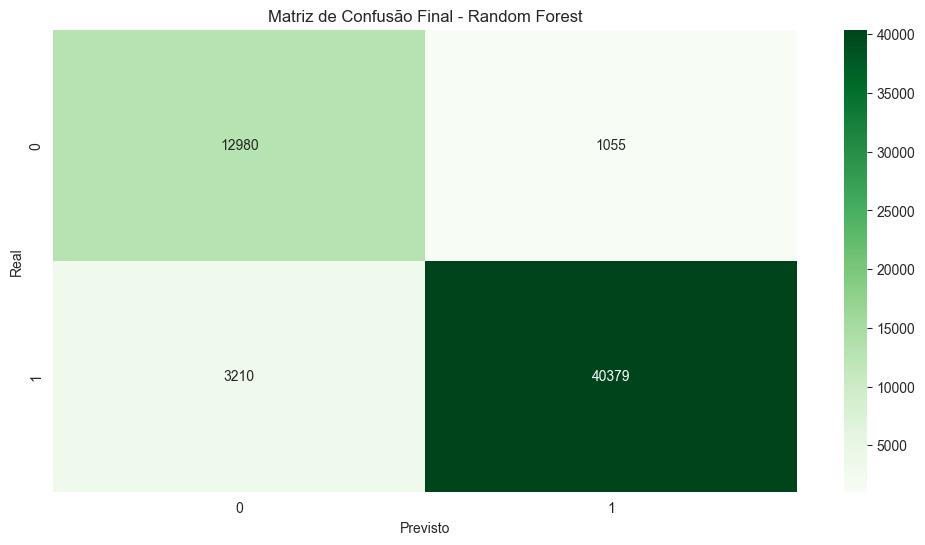

In [127]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Configurar o pipeline final com os melhores componentes e parâmetros
final_model = models[best_model_name]
final_sampler = samplers[best_sampler_name]

# Remover o prefixo 'classifier__' dos nomes dos parâmetros
cleaned_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}
final_model.set_params(**cleaned_params)

final_pipeline = ImbPipeline(steps=[('sampler', final_sampler),
                                    ('classifier', final_model)])

# 2. Treinar o modelo final em TODOS os dados de treino (já pré-processados)
final_pipeline.fit(X_train_processed, y_train)

# 3. Fazer previsões no conjunto de teste (já pré-processado)
y_pred_final = final_pipeline.predict(X_test_processed)

# 4. Avaliar a performance final
print(f"--- Relatório de Classificação Final para: {best_model_name} com {best_sampler_name} ---")
print(classification_report(y_test, y_pred_final))

# Matriz de Confusão
cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens')
plt.title(f'Matriz de Confusão Final - {best_model_name}')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

# 7. Conclusão e Exportação do Modelo

In [128]:
# 6. Salvar o modelo final
# IMPORTANTE: Salvaremos a pipeline final, que sabe balancear e classificar.
# O pré-processador ('feature_preprocessor.pkl') também deve ser guardado.
joblib.dump(final_pipeline, 'best_classifier_pipeline.pkl')
print("\n✅ Pipeline final (sampler + classifier) salva com sucesso como 'best_classifier_pipeline.pkl'")
print("Lembre-se de usar também o 'feature_preprocessor.pkl' salvo anteriormente ao usar o modelo.")


✅ Pipeline final (sampler + classifier) salva com sucesso como 'best_classifier_pipeline.pkl'
Lembre-se de usar também o 'feature_preprocessor.pkl' salvo anteriormente ao usar o modelo.


Iniciando busca pelo limiar ótimo...

🏆 Melhor Limiar Encontrado: 0.20
   Com F1-Score (macro avg) de: 0.9101

--- Relatório de Classificação Final com Limiar Otimizado ---
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     14035
           1       0.96      0.95      0.96     43589

    accuracy                           0.93     57624
   macro avg       0.90      0.92      0.91     57624
weighted avg       0.93      0.93      0.93     57624



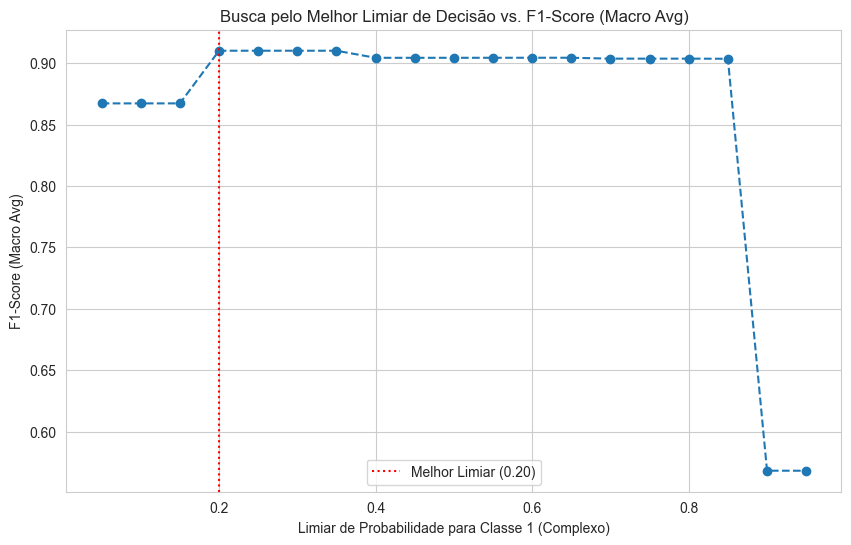

In [129]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

# 1. Carregar o melhor pipeline treinado e o pré-processador
final_pipeline = joblib.load('best_classifier_pipeline.pkl')
# Não precisamos carregar o preprocessor aqui, pois já temos os dados processados

print("Iniciando busca pelo limiar ótimo...")

# 2. Obter as probabilidades para o conjunto de teste JÁ PROCESSADO
# --- CORREÇÃO AQUI ---
# Usamos X_test_processed em vez de X_test
y_pred_probs = final_pipeline.predict_proba(X_test_processed)[:, 1]

# 3. Encontrar o melhor limiar testando vários valores
thresholds = np.arange(0.05, 1.0, 0.05)
f1_scores = []

for thresh in thresholds:
    y_pred_tuned = (y_pred_probs >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_tuned, average='macro')
    f1_scores.append(f1)

# Encontrar o limiar que maximizou o F1-Score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f"\n🏆 Melhor Limiar Encontrado: {best_threshold:.2f}")
print(f"   Com F1-Score (macro avg) de: {best_f1_score:.4f}")

# 4. Avaliar o modelo final com o limiar otimizado
y_pred_final_tuned = (y_pred_probs >= best_threshold).astype(int)

print("\n--- Relatório de Classificação Final com Limiar Otimizado ---")
print(classification_report(y_test, y_pred_final_tuned))

# 5. Visualizar a busca pelo melhor limiar
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o', linestyle='--')
plt.title('Busca pelo Melhor Limiar de Decisão vs. F1-Score (Macro Avg)')
plt.xlabel('Limiar de Probabilidade para Classe 1 (Complexo)')
plt.ylabel('F1-Score (Macro Avg)')
plt.axvline(best_threshold, color='r', linestyle=':', label=f'Melhor Limiar ({best_threshold:.2f})')
plt.legend()
plt.grid(True)
plt.show()